# <center>Exploratory Data Analysis</center>
## <center>W251 Final Project</center>
### <center>Group: Josh, Mark, Clay</center>


## 1. Load Data

In [1]:
import re
import ast
import time
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = application_1545094219751_0015


In [2]:
from pyspark.sql import SparkSession
app_name = "w251_final_project"
#master = "local[*]"

spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext


In [3]:
#confirm data exists in HDFS - if not run code at end of EDA Notebook
!hdfs dfs -ls /data

Found 53 items
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:29 /data/ak
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:29 /data/al
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:31 /data/ar
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:30 /data/az
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:36 /data/ca
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:39 /data/co
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:40 /data/ct
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:40 /data/dc
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:40 /data/de
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:44 /data/fl
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:52 /data/ga
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:52 /data/hi
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 02:03 /data/ia
drwxr-xr-x   - clsadmin bihdfs          0 2018-12-18 01:54 /data/id
drwxr-xr-x   - clsadmin bihdfs   

In [3]:
# load data from HDFS to an RDD for spark analysis
fullRDD = sc.textFile("/data/*/*")

In [4]:
fullRDD.take(2)

[u'LON,LAT,NUMBER,STREET,UNIT,CITY,DISTRICT,REGION,POSTCODE,ID,HASH',
 u'-149.4672014,61.4253086,22706,OAK KNOLL DR,,,,,99567,,d6285d518414f07e']

In [46]:
# Generate 0.1% miniRDD for code testing before running on full data set
trainRDD, miniRDD = fullRDD.randomSplit([0.999,0.001], seed = 1)
miniRDD.cache()
print("... created a miniRDD of {:,} records for testing.".format(miniRDD.count()))

... created a miniRDD of 151,307 records for testing.


## 2. Quick and Dirty Zip Code EDA on OpenAddresses Data Set - replaced Zips / FIPS inferrence

In [47]:
def getUniqueZip(line):
    #long, lat, house_num, street, unit, city, district, region, postcode, some_id, some_hash = line
    
    if len(line) != 11:
        yield ('***empty', 1)
    
    elif line[8] == "":
        yield ('***blank', 1)
    else:
        postcode_short = line[8]
        yield (postcode_short, 1)

uniqueRDD = miniRDD.map(lambda line: line.split(',')) \
                   .flatMap(getUniqueZip) \
                   .reduceByKey(lambda x, y: x+y).collect()


In [86]:
uniqueRDD

[('32680', 3),
 ('13780', 1),
 ('43123', 21),
 ('33603', 8),
 ('02494', 11),
 ('46745', 1),
 ('98005', 9),
 ('28054', 13),
 ('48084-2685', 1),
 ('97206', 51),
 ('11725', 5),
 ('19104-1417', 1),
 ('59868', 2),
 ('49348', 3),
 ('27591', 6),
 ('92319', 1),
 ('19134-3154', 1),
 ('62513', 2),
 ('35143', 4),
 ('01450', 8),
 ('96732', 3),
 ('47394', 7),
 ('80021', 32),
 ('57476', 1),
 ('27890', 1),
 ('20191', 27),
 ('27809', 2),
 ('46601', 1),
 ('14215 1905', 1),
 ('06051', 9),
 ('12966', 3),
 ('30303', 2),
 ('63134', 7),
 ('50169', 2),
 ('64064', 6),
 ('68152', 4),
 ('34475', 10),
 ('93906', 17),
 ('46181', 2),
 ('60563', 6),
 ('26205', 7),
 ('98223-6890', 1),
 ('93270', 4),
 ('13730', 2),
 ('32226', 18),
 ('54824', 3),
 ('14214 1208', 1),
 ('19146-1713', 1),
 ('60123', 23),
 ('27503', 6),
 ('33953', 29),
 ('78839', 1),
 ('20721', 23),
 ('98026-7065', 1),
 ('740555565', 1),
 ('19148-2609', 1),
 ('96782', 5),
 ('21659', 1),
 ('60487', 4),
 ('33572', 13),
 ('98632', 31),
 ('14227', 13),
 ('448

## 3. IRS File EDA

In [5]:
# load the file
irsRDD = sc.textFile("/data/tax_return_data.csv").cache()

In [305]:
# get total number of records
irsRDD.count()

179797

In [92]:
# peek at sample data
irsRDD.take(4)

['STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,PREP,N2,NUMDEP,TOTAL_VITA,VITA,TCE,VITA_EIC,RAL,RAC,ELDERLY,A00100,N02650,A02650,N00200,A00200,N00300,A00300,N00600,A00600,N00650,A00650,N00700,A00700,N00900,A00900,N01000,A01000,N01400,A01400,N01700,A01700,SCHF,N02300,A02300,N02500,A02500,N26270,A26270,N02900,A02900,N03220,A03220,N03300,A03300,N03270,A03270,N03150,A03150,N03210,A03210,N03230,A03230,N03240,A03240,N04470,A04470,A00101,N17000,A17000,N18425,A18425,N18450,A18450,N18500,A18500,N18800,A18800,N18300,A18300,N19300,A19300,N19500,A19500,N19530,A19530,N19550,A19550,N19570,A19570,N19700,A19700,N20800,A20800,n21020,a21020,N04800,A04800,N05800,A05800,N09600,A09600,N05780,A05780,N07100,A07100,N07300,A07300,N07180,A07180,N07230,A07230,N07240,A07240,N07220,A07220,N07260,A07260,N09400,A09400,N85770,A85770,N85775,A85775,N09750,A09750,N10600,A10600,N59660,A59660,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A119

In [6]:
def getIRSZip(line):
    '''
    input:  takes full input from irsRDD to isolate zip code fields
    output:  count by zip code and blanks
    '''
    if len(line[2]) < 5:
        yield ('***blank', 1)
    else:
        yield (line[2], 1)

In [7]:
# spark job to get Zip Code data from IRS File
irsZipRDD = irsRDD.map(lambda line: line.split(',')) \
                  .flatMap(getIRSZip) \
                  .reduceByKey(lambda x,y: x+y)

In [8]:
irsZipRDD.takeOrdered(10, key = lambda x: -x[1])

[('***blank', 14248),
 (u'99999', 306),
 (u'35540', 6),
 (u'35234', 6),
 (u'35544', 6),
 (u'60416', 6),
 (u'35546', 6),
 (u'35548', 6),
 (u'53001', 6),
 (u'73463', 6)]

In [9]:
# get a count of uniqe zip codes in data set
irsZipRDD.count()

27551

## 4. OpenAddresses EDA - Records and Lines

### 4.1 Data Analysis - Loop over Files in HDFS getting counts of Files, Lines per Value to Accumulate by State

In [250]:
statesCap = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
states = [x.lower() for x in statesCap]

In [251]:
hdfsPath = '/data/'
localPath = '/home/wce/clsadmin/data/us/'

In [252]:
# define holder variables
stateCounties = defaultdict(str) # dictionary by state (key) and number of county files (value)
totalCounties = 0                # running tall of total files
stateLines = defaultdict(int)    # dictionary by state (key) and running count of lines across all files
totalLines = 0                   # running tall of total lines across entire data set

# loop over the files
for state in states:
    # define state file path
    os.chdir(localPath + state + '/')
    # get list of county files by state
    counties = [doc for doc in os.listdir(".") if doc.endswith((".csv"))]
    
    stateCounties[state] = len(counties)
    totalCounties += len(counties)
    
    # count the records in each file
    for file in counties:
        file_csv = localPath + state + '/' + file
        
        # get row count and update dictionary and running tally
        rowcount = len(open(file_csv).readlines())
        stateLines[state] += rowcount
        totalLines += rowcount

In [253]:
avgLines = defaultdict(int)

for state in states:
    avgLines[state] = int(stateLines[state] / stateCounties[state])

In [257]:
# cacluate data set averages
meanCounties = sum(stateCounties.values()) / 51
meanLines = sum(stateLines.values()) /51
meanCounties, meanLines

(27, 3150782)

In [258]:
min(stateLines.values()), max(stateLines.values())

(107490, 22444822)

In [256]:
totalCounties, totalLines

(1394, 160689883)

### 4.2 Chart Records and File Data

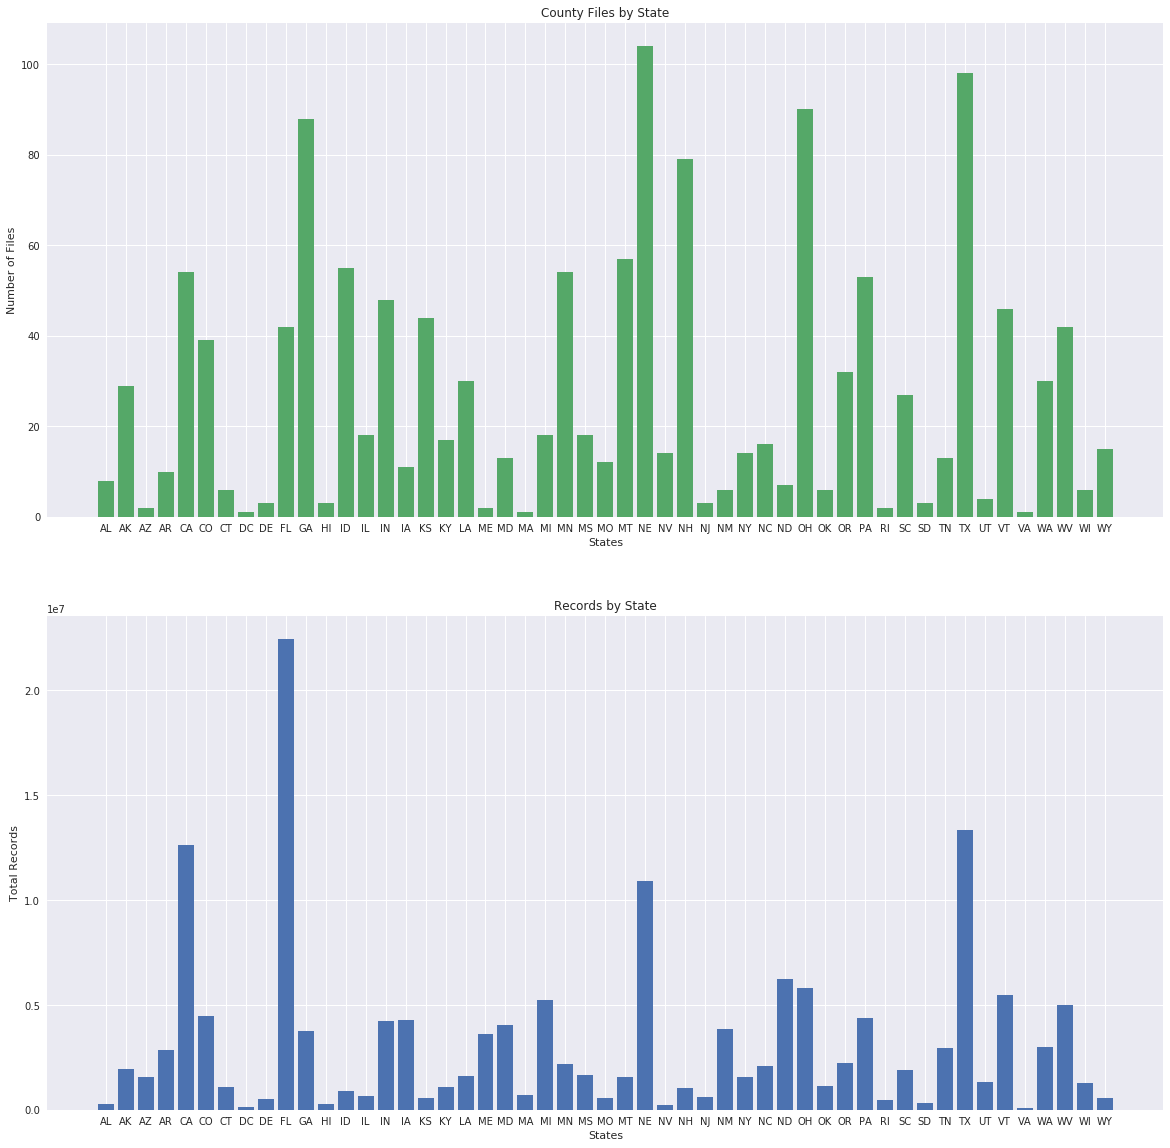

In [45]:
data_set = [stateCounties, stateLines]
titles = ['County Files by State', 'Records by State']
ylables = ['Number of Files', 'Total Records']
plt.figure(0, figsize=(20,20))
fig = plt.figure(0)

for chart in range(2):
    ax = fig.add_subplot(2,1,chart+1)
    data = data_set[chart]
    
    # order values alphabetically
    plot_data = []
    for num in sorted(data.iterkeys()):
        plot_data.append(data[num])

    ax.bar(range(len(data)), plot_data, align='center', tick_label = statesCap)
    ax.set_title(titles[chart])
    plt.xlabel("States")
    plt.ylabel(ylables[chart])
plt.show()

In [47]:
# show averages by state
avgLines

defaultdict(int,
            {'ak': 35107,
             'al': 67303,
             'ar': 771340,
             'az': 287402,
             'ca': 234200,
             'co': 114492,
             'ct': 183693,
             'dc': 147400,
             'de': 167625,
             'fl': 534400,
             'ga': 42612,
             'hi': 90090,
             'ia': 15961,
             'id': 36553,
             'il': 88307,
             'in': 390286,
             'ks': 12713,
             'ky': 63625,
             'la': 53554,
             'ma': 1806585,
             'md': 312410,
             'me': 690404,
             'mi': 290901,
             'mn': 40571,
             'mo': 92260,
             'ms': 46596,
             'mt': 27106,
             'nc': 104702,
             'nd': 15119,
             'ne': 13414,
             'nh': 197210,
             'nj': 645907,
             'nm': 113078,
             'nv': 131922,
             'ny': 888844,
             'oh': 64595,
             'ok': 189434,


## 5. OpenAddresses Count of Missing Data Points by State

### 5.1 Code to get blanks by state and attribute

In [75]:
def getBlanks(line):
    '''
    function to find blanks from 11 field OpenAddress RDD
    input:  comma seperated line of 11 data points
    output: count of missing fields by state-attribute and total state count of blanks
    '''
    if len(line) != 11:
        yield ('***incomplete', 1)    
    else:
        fields = ['long', 'lat', 'house_num', 'street', 'unit', 'city', 'district', 'region', 'postcode', 'some_id', 'some_hash']
        long, lat, house_num, street, unit, city, district, region, postcode, some_id, some_hash = line
        blanks = 0
        
        # get current state file
        state = bcState.value
        
        for i in range(len(line)):
            if line[i] == "":
                blanks += 1
                yield (str(state) +'-'+ fields[i], 1)
            
        yield (state, blanks)

In [279]:
start = time.time()

# define holder variables
stateBlanks = defaultdict(int)
incompleteRecords = defaultdict(int)
rawOutput = []
missingFields = defaultdict(int)

# loop over the files
for state in states:
    # broadcast state varaible for use in getBlanks helper function
    bcState = sc.broadcast(state)
    
    # define state file path
    os.chdir(localPath + state + '/')
    # get list of county files
    counties = [doc for doc in os.listdir(".") if doc.endswith((".csv"))]
    
    # count the records in each file
    for file in counties:
        blanks = []
        #skip strange file
        if file == '_loveland.csv':
            continue
        
        # find file in HDFS / load RDD for parallel computing
        file_csv = hdfsPath + state + '/' + file
        countyRDD = sc.textFile(file_csv)
        county_name = file_csv.split('.')[0]
        bcCounty = sc.broadcast(county_name)
        
        # spark job to get blanks by county file
        blanks = countyRDD.map(lambda line: line.split(',')) \
                          .flatMap(getBlanks) \
                          .reduceByKey(lambda x, y: x+y).collect()
        blanksDict = dict(blanks)
        
        # update state dictionary
        for output in blanksDict:
            if state == output:
                stateBlanks[output] += blanksDict[output]
            elif '***incomplete' == output:
                incompleteRecords[output] += blanksDict[output]
            else:
                continue
        
        # capture blank information by field
        for i in range(len(blanks)):
            
            if len(blanks[i][0]) == 2 or blanks[i][0] == '***incomplete':
                continue
            else:
                key = blanks[i][0].split('-')[1]
                value = blanks[i][1]
                missingFields[key] += value
        
    interval = time.time()    
    print("{} finished, in {} seconds".format(state,round(interval - time.time(),5)))
print("job ran in {} minutes.".format(round((time.time()-start)/60,2)))        

al finished, in 0.0 seconds
ak finished, in 0.0 seconds
az finished, in 0.0 seconds
ar finished, in 0.0 seconds
ca finished, in 0.0 seconds
co finished, in 0.0 seconds
ct finished, in 0.0 seconds
dc finished, in 0.0 seconds
de finished, in 0.0 seconds
fl finished, in 0.0 seconds
ga finished, in 0.0 seconds
hi finished, in 0.0 seconds
id finished, in 0.0 seconds
il finished, in 0.0 seconds
in finished, in 0.0 seconds
ia finished, in 0.0 seconds
ks finished, in 0.0 seconds
ky finished, in 0.0 seconds
la finished, in 0.0 seconds
me finished, in 0.0 seconds
md finished, in 0.0 seconds
ma finished, in 0.0 seconds
mi finished, in 0.0 seconds
mn finished, in 0.0 seconds
ms finished, in 0.0 seconds
mo finished, in 0.0 seconds
mt finished, in 0.0 seconds
ne finished, in 0.0 seconds
nv finished, in 0.0 seconds
nh finished, in 0.0 seconds
nj finished, in 0.0 seconds
nm finished, in 0.0 seconds
ny finished, in 0.0 seconds
nc finished, in 0.0 seconds
nd finished, in 0.0 seconds
oh finished, in 0.0 

#### 5.1.1 Summary Statistics of Blanks

In [170]:
print("Total blanks:  {:,}".format(sum(stateBlanks.values())))

Total blanks:  583,177,870


In [174]:
print("Total records: {:,}".format(fullRDD.count() * 11))

Total records: 1,666,231,864


In [285]:
missingFields

defaultdict(int,
            {'city': 53696018,
             'district': 111468473,
             'house_num': 11021073,
             'postcode': 41614986,
             'region': 94552512,
             'some_hash': 1657047,
             'some_id': 121112313,
             'street': 9334233,
             'unit': 138721215})

### 5.2 Chart Missing Records

#### 5.2.1 Missing Fields by Field Type

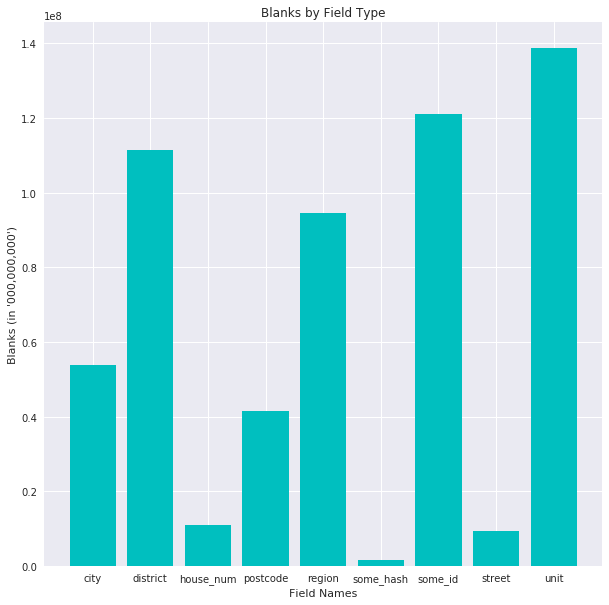

In [304]:
lables = ['city',
 'district',
 'region',
 'some_hash',
 'street',
 'postcode',
 'some_id',
 'house_num',
 'unit']
lables.sort()

plt.figure(0, figsize=(10,10))
fig = plt.figure(0)


ax = fig.add_subplot(1,1,1)
data = missingFields

# order values alphabetically
plot_data = []
for num in sorted(missingFields.iterkeys()):
    plot_data.append(missingFields[num])

ax.bar(range(len(missingFields)), plot_data, align='center', tick_label = lables, color = ['c'])
ax.set_title('Blanks by Field Type')
plt.xlabel("Field Names")
plt.ylabel("Blanks (in '000,000,000')")

plt.show()

#### 5.2.2 Blanks by State

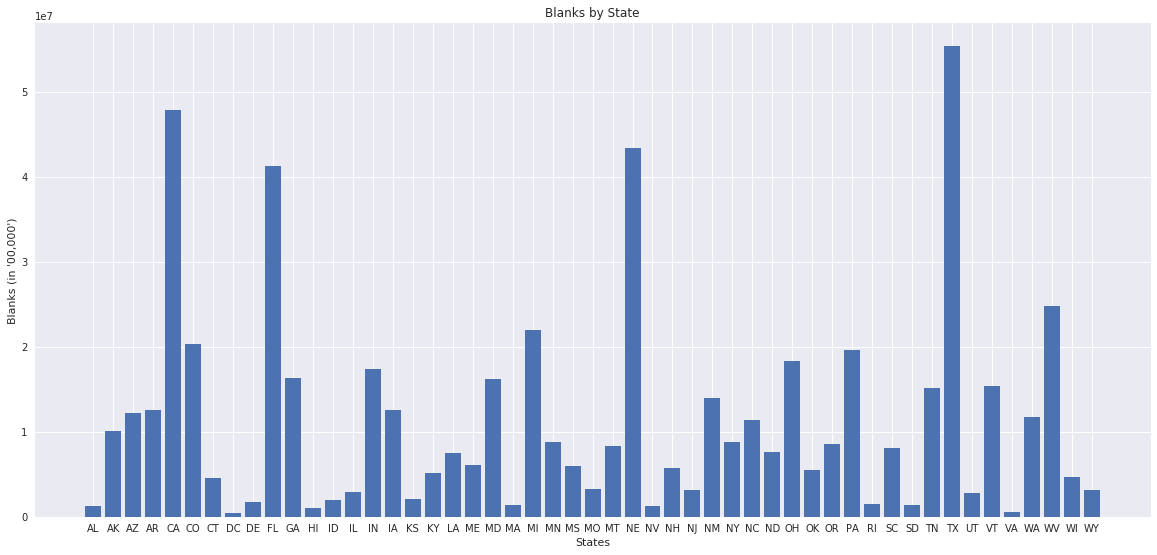

In [199]:
plt.figure(0, figsize=(20,20))
fig = plt.figure(0)


ax = fig.add_subplot(2,1,chart+1)
data = data_set[chart]

# order values alphabetically
plot_data = []
for num in sorted(stateBlanks.iterkeys()):
    plot_data.append(stateBlanks[num])

ax.bar(range(len(stateBlanks)), plot_data, align='center', tick_label = statesCap)
ax.set_title('Blanks by State')
plt.xlabel("States")
plt.ylabel("Blanks (in '00,000')")

plt.show()

#### 5.2.3 Blanks Summary

In [196]:
empty = stateBlanks.values() #583177870
total = fullRDD.count() * 11) #1666231864
filled = total-empty
empty/float(total)

0.34999803004607527

In [191]:
data

[583177870, 1083053994, 1666231864]

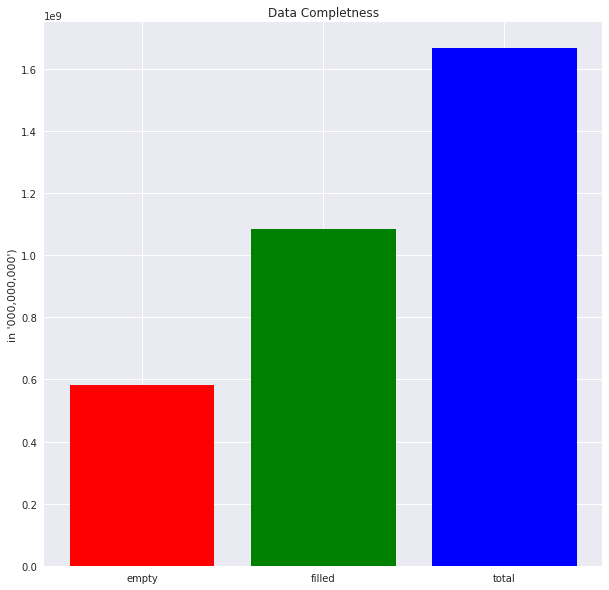

In [203]:
empty = stateBlanks.values()  # 583177870
total = fullRDD.count() * 11) #1666231864
filled = total-empty

plt.figure(0, figsize=(10,10))
fig = plt.figure(0)
ax = fig.add_subplot(1,1,1)
data = [empty, filled, total]

ax.bar(range(len(data)), data, align='center', tick_label = ['empty', 'filled', 'total'], color = ['red', 'green', 'blue'])
ax.set_title('Data Completness')
#plt.xlabel("States")
plt.ylabel("in '000,000,000')")

plt.show()

# plt.figure(0, figsize=(20,20))
# fig = plt.figure(0)


# ax = fig.add_subplot(2,1,chart+1)
# data = data_set[chart]



# APPENDIX - Data Load to HDFS

In [ ]:
import os
import time
import subprocess
from collections import defaultdict

# define flie locations
hdfsPath = '/data/'
localPath = '/home/wce/clsadmin/data/us/'
irsPath = '/home/wce/clsadmin/data/tax_return_data.csv' # includes file name

# define state list
statesCap = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
states = [x.lower() for x in statesCap]

# define HDFS command function
def run_cmd(args_list, verbose = False):
    if verbose == True:
        print('Running system command: {0}'.format(' '.join(args_list)))
    proc = subprocess.Popen(args_list, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    s_output, s_err = proc.communicate()
    s_return = proc.returncode
    return s_return, s_output, s_err

# build directry structre in HDFS
start = time.time()
stateFiles = 0
(ret, out, err) = run_cmd(['hdfs', 'dfs', '-mkdir', hdfsPath])
for state in states:
    location = hdfsPath + state + '/'
    (ret, out, err) = run_cmd(['hdfs', 'dfs', '-mkdir', location])
    stateFiles +=1
print("Created {} subfolders in hdfs dfs {}".format(stateFiles, hdfsPath))
print("Directory took {} minutes".format(round((time.time()-start)/60,2)))

# upload IRS data file
(ret, out, err) = run_cmd(['hdfs', 'dfs', '-put', irsPath, hdfsPath])
print("Added IRS data file to {}".format(hdfsPath))

start = time.time()
totFiles = 0
stateSummary = defaultdict(int)

# get county name list of .csv files
for state in states:
    # define state file path
    os.chdir(localPath + state + '/')
    # get list of county files
    counties = [doc for doc in os.listdir(".") if doc.endswith((".csv"))]

    for file in counties:
        # define file location
        hdfsLoc = hdfsPath + state + '/' + file
        fileLoc = localPath + state + '/' + file

        # Run Hadoop put command in Python
        (ret, out, err) = run_cmd(['hdfs', 'dfs', '-put', fileLoc, hdfsLoc])
        totFiles += 1
        stateSummary[state] += 1

    print("Completed {}".format(state))
    #print(counties)
    # path = "/root/final_projects/us"os.chdir(path)YY = [doc for doc in os.listdir() if (doc.endswith((".csv"))


print("Files loaded in {} minutes".format(round((time.time()-start)/60,2)))
print("Total files:  {}".format(totFiles))
print("State Check:  {}.  Should be 51".format(len(stateSummary)))
print("Files by State:  {}".format(stateSummary))